![](http://)你好，我是七月在线fan:  
print("julyfedu")是为了防中断  
文档会不定期更新  
建议去kaggle fork运行代码，可以不用下载数据集和配置环境，还有免费的gpu。这篇kernel已被fan私有，其他人看不见，可以和群里的fan私聊,申请授权。  
有问题请指出！感谢！  
转载请注明出处  
这是原作者的kernel：  
https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai/  
这是七月在线的网址：  
https://www.julyedu.com/

补充资料 One Page Knowledge   https://alexiej.github.io/deepnn/#gpu-servers

-------------------------
# Validation and analysis 验证和分析  
Now the training is done.现在训练已经完成了  

## How good does the model perform technically?  该模型在技术上有多好？

e can only get metrics from our validation set, and the final test metrics will be most likely a bit different.
我们只能从验证集中看到指标，最终测试集上的指标很可能会有所不同。

In [2]:
def augment_images(images: np.ndarray, center_crop_size=(48, 48)):
    # center crop
    cropped: np.ndarray = np.zeros(shape=(images.shape[0], center_crop_size[0], center_crop_size[1], images.shape[-1]),
                                   dtype=np.uint8)
    for i in range(len(images)):
        centerw, centerh = images[i].shape[0] // 2, images[i].shape[1] // 2
        halfw, halfh = center_crop_size[0] // 2, center_crop_size[1] // 2
        cropped[i] = images[i][centerw - halfw: centerw + halfw,
                     centerh - halfh: centerh + halfh, :]
    seq = iaa.Sequential([
        #         iaa.Crop(px=(0, 16), keep_size=True, name="crop"),
        iaa.Fliplr(0.5, name="Flipper_h"),
        iaa.Flipud(0.5, name="Flipper_V"),
        #         iaa.GaussianBlur((0, 3.0), name="GaussianBlur"),
        iaa.Dropout(0.02, name="Dropout"),
        iaa.AdditiveGaussianNoise(scale=0.01 * 255, name="MyLittleNoise"),
        iaa.AdditiveGaussianNoise(loc=32, scale=0.0001 * 255, name="SomeOtherNoise"),
        iaa.AffineCv2(
            #                       scale=(0.8, 1.1),
            rotate=(-30, 30), name="affine_rotate", cval=(100, 200),
            translate_px={"x": (-10, 10), "y": (-10, 10)}
        )
    ])
    seq_det = seq.to_deterministic()  # call this for each batch again, NOT only once at the start
    return seq_det.augment_images(cropped)

myfont = FontProperties(fname='simhei.ttf') 

In [3]:
from fastai.vision import get_files, ImageList, Path, Image, tensor, df_names_to_idx
import numpy as np
import os
import h5py

class H5pyList(ImageList):
    
    def open(self, fn, dsn, imgidx):
        with h5py.File(fn, 'r') as f:
            img=f[dsn][imgidx][()]
            img=augment_images(img[np.newaxis,...],center_crop_size=(96,96))
#             img = img[0]
#             img=np.swapaxes(img,0,1)
            return vision.Image(px=pil2tensor(img[0]/255, np.float32))

    def get(self, idx):
        item = self.items[idx]
        res = self.open(item[0], item[1], item[2])
        self.sizes[idx] = res.size
        return res

    def _append_h5py_items(item_list, fns):
        for file in fns:
            with h5py.File(file, 'r') as f:
                for name in f:
                    item_list.append([Path(file), name])
        return item_list

    def add_prefix_suffix(fns, path, folder, suffix):
        pref = f'{path}{os.path.sep}'
        if folder is not None:
            pref += f'{folder}{os.path.sep}'
        return np.char.add(np.char.add(pref, fns.astype(str)), suffix)

    @classmethod
    def from_file(cls, path, **kwargs):
        """This function makes an H5pyList from all of the datasets in a given file"""
        items = []
        path = Path(path)
        with h5py.File(path, 'r') as f:
            for name in f:
                items.append((path, name))
        return cls(items, path=path.parent, **kwargs)

    @classmethod
    def from_folder(cls, path, recurse=True, **kwargs):
        """This function makes a H5pyList from all the datasets in all the files of a given folder"""
        items = []
        path = Path(path)
        fns = get_files(path, recurse=recurse, extensions='.h5py')
        cls._append_h5py_items(items, fns)
        return cls(items, path=path, **kwargs)

    @classmethod
    def from_df(cls, df, path, cols,
                dsn_col=None,imgsidx=0, folder=None, suffix='', **kwargs):
        """Use dsn_col if your df contains an entry for the name of every dataset paired with its corresponding
           filename. The filenames must be in a single column. This function does not allow you to use
           label_from_df unless you include a dsn_col."""
        if dsn_col is not None:
            return cls.from_detailed_df(df, path, cols, dsn_col, imgsidx, folder, suffix, **kwargs)
        suffix = suffix or ''
        path = Path(path)
        inputs = df.iloc[:, df_names_to_idx(cols, df)]
        assert inputs.isna().sum().sum() == 0, f"You have NaN values in column(s) {cols} of your dataframe, please fix it."
        files = cls.add_prefix_suffix(inputs.values.flatten(), path, folder, suffix)
        items = []
        cls._append_h5py_items(items, files)
        return cls(items, path=path, **kwargs)

    @classmethod
    def from_detailed_df(cls, df, path, fn_col, dsn_col, imgsidx,
                         folder=None, suffix='', **kwargs):
        """This function is called by from_df if dsn_col is passed into it."""
        suffix = suffix or ''
        path = Path(path)
        if not (isinstance(fn_col, int) and isinstance(dsn_col, int)):
            raise "Filenames and dataset names must each be in a single column"
        fn_inputs = df.iloc[:, fn_col]
        ds_inputs = df.iloc[:, dsn_col]
        imgs_idx =  df.iloc[:, imgsidx]
        assert fn_inputs.isna().sum().sum() + ds_inputs.isna().sum().sum() == 0, f"You have NaN values in column(s) {[fn_col, dsn_col]} of your dataframe, please fix it."
        files = cls.add_prefix_suffix(fn_inputs.values.flatten(), path, folder, suffix)
        items = [[f, ds, fidx] for f, ds, fidx in zip(files, ds_inputs.values.flatten(), imgs_idx.values.flatten())]
        return cls(items, path=path, inner_df=df, **kwargs)

In [4]:
import pandas as pd
dict={'train_images1': 10998, 'train_images2': 11005, 'train_images3': 11002, 'train_images4': 11006, 'train_images5': 11006, 'train_images6': 10988, 'train_images7': 11001, 'train_images8': 10984, 'train_images9': 11001, 'train_images10': 11010, 'train_images11': 11005, 'train_images12': 10991, 'train_images13': 10984, 'train_images14': 11005, 'train_images15': 11006, 'train_images16': 11016, 'train_images17': 10996, 'train_images18': 11005, 'train_images19': 11000, 'train_images20': 11016}
fns = []
dsns = []
imgs_idx=[]
a=pd.read_csv('labels.csv')
labels=[]

tfns=[]
tdsns=[]
timgidx=[]
test_images_nbs=10

for i in range(220025):
    labels.append(str(a['label'][i]).split(' ')[1].replace('b','').replace('\'','').replace(']',''))
for i in range(1,21):
    for j in range(dict[f'train_images{i}']):
        fns.append('histro_train.h5')
        dsns.append(f'train_images{str(i)}')
        imgs_idx.append(int(j))
for i in range(test_images_nbs):
#     tfns.append('histro_train.h5')
    tfns.append('histro_test.h5')
    tdsns.append('test_images')
    timgidx.append(int(i))
detailed_df = pd.DataFrame({'Fn':fns, 'Ds':dsns,'Label':labels, 'Ids':imgs_idx})
test_df = pd.DataFrame({'Fn':tfns, 'Ds':tdsns, 'Ids':timgidx})
# detailed_df_il = H5pyList.from_df(detailed_df, path='./histo', cols=0, dsn_col=1,imgsidx=3)
# detailed_df_il

In [5]:
imgDataBunch = (H5pyList.from_df(detailed_df, path='./histo', cols=0, dsn_col=1,imgsidx=3) # 根据训练集dataframe的列中的路径创建torch中的ItemList
        .split_by_rand_pct(.2, seed=42)
        .label_from_df(cols=2)
        .add_test(H5pyList.from_df(test_df, path='./histo', cols=0, dsn_col=1,imgsidx=2)) # 设置测试集 这里使用的是自定义的数据导入方式MyImageItemList，
        .databunch(bs=BATCH_SIZE) # 将训练集、验证集、测试集捆绑成一个对象
        .normalize([tensor([0.702447, 0.546243, 0.696453]), tensor([0.238893, 0.282094, 0.216251])])
       )

In [6]:
imgDataBunch

ImageDataBunch;

Train: LabelList (176020 items)
x: H5pyList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,0,1,0,0
Path: histo;

Valid: LabelList (44005 items)
x: H5pyList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,1,0,0,1
Path: histo;

Test: LabelList (10 items)
x: H5pyList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: histo

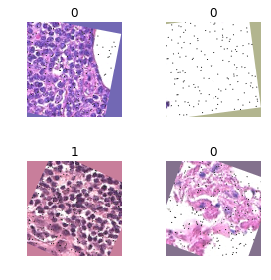

In [18]:
imgDataBunch.show_batch(rows=2, figsize=(4,4)) 

In [7]:
# if the model was better before finetuning, uncomment this to load the previous stage 如果在微调之前的模型反而更好，则取消注释 ，加载前一阶段的模型，进行验证分析。
import h5py
import numpy as np
from tqdm import tqdm_notebook
from matplotlib.font_manager import *  

import imgaug.augmenters as iaa
import numpy as np
from fastai import * # 更快、更简单、更先进的深度学习库
from fastai.vision import * # fastai中包含定义计算机视觉中的数据集和训练模型所必须的函数
from torchvision.models import *    # import *=all the models from torchvision  pytorch计算机视觉模型

BATCH_SIZE = 128
import random # 生成随机变量
ORIGINAL_SIZE = 96      # original size of the images - do not change原始图片尺寸
CROP_SIZE = 90          # final size after crop剪裁后的图片大小
RANDOM_ROTATION = 3    # range (0-180), 180 allows all rotation variations, 0=no change旋转角度
RANDOM_SHIFT = 2        
RANDOM_BRIGHTNESS = 7  # range (0-100), 0=no change 随机亮度 给图像每个像素加上一个在(-1,1)间的随机值
RANDOM_CONTRAST = 5    # range (0-100), 0=no change 随机对比度 给图像每个像素乘上一个在(0,2)间的随机值
RANDOM_90_DEG_TURN = 1  # 0 or 1= random turn to left or right向左或右旋转90度
sz = CROP_SIZE                      # input size is the crop size 输入的图像尺寸 (图像增强后是90*90)

import torchvision
import os
arch = torchvision.models.densenet.densenet169  
MODEL_PATH='densenet169'
def getLearner(): 
    return cnn_learner(imgDataBunch, arch, pretrained=True, path='.', metrics=accuracy, ps=0.5, callback_fns=ShowGraph)
learner = getLearner() # 创建一个卷积神经网络学习器
learner.load(MODEL_PATH + '_stage2') 

/usr/local/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Learner(data=ImageDataBunch;

Train: LabelList (176020 items)
x: H5pyList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,0,1,0,0
Path: histo;

Valid: LabelList (44005 items)
x: H5pyList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,1,0,0,1
Path: histo;

Test: LabelList (10 items)
x: H5pyList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: histo, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): Batch

In [9]:
learner.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 48, 48]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 48, 48]         128        True      
______________________________________________________________________
ReLU                 [64, 48, 48]         0          False     
______________________________________________________________________
MaxPool2d            [64, 24, 24]         0          False     
______________________________________________________________________
BatchNorm2d          [64, 24, 24]         128        True      
______________________________________________________________________
ReLU                 [64, 24, 24]         0          False     
______________________________________________________________________
Conv2d               [128, 24, 24]        8,192      False     
___________________________________________________

In [10]:
preds,y, loss = learner.get_preds(with_loss=True) # 预测、预测标记、损失值 https://docs.fast.ai/basic_train.html#Learner.get_preds
# get accuracy
acc = accuracy(preds, y) # 计算精度 https://docs.fast.ai/metrics.html#accuracy
print('The accuracy is {0} %.'.format(acc))

The accuracy is 0.9737756848335266 %.


西瓜书：  
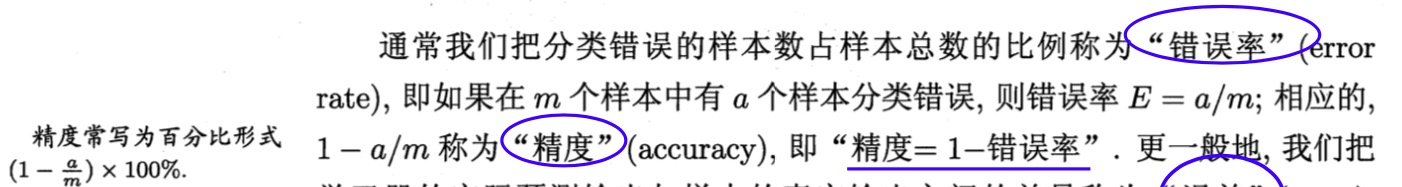

## How good is the model in terms of project requirements? 模型在项目要求方面有多好？
It is a good idea to look at examples of images from:  查看图像的示例是个好主意：  

- Random samples 随机样本
    - Some random predictions 一些随机样本的预测
- The most incorrectly labeled 最不正确的标签
    - What our model predicts wrong with very high probability. 我们的模型以非常高的概率预测错误的数据是什么。
- The most correctly labeled 最正确的标签
    - What our model is most confident of and gets right. 我们的模型最有信心，也是最正确的数据是什么。
    
This visualization is a good way of understanding what are the images the model struggles with. It might also reveal something about the dataset such as bad quality data.   
这种可视化是了解模型所面对的数据的好方法。 它还可能揭示有关数据集的一些信息，例如质量不佳的数据。

In [11]:
# I modified this from the fastai's plot_top_losses (https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L114)
from random import randint # 随机生成一个整数

def plot_overview(interp:ClassificationInterpretation, classes=['Negative','Tumor']): 
    # interp 是 ClassificationInterpretation 分类模型的效果解释函数 https://docs.fast.ai/vision.learner.html#ClassificationInterpretation
    
    # top losses will return all validation losses and indexes sorted by the largest first
    # top_losses 将返回所有 验证集的损失值(tl_val)和其索引(tl_idx) 按降序排序
    tl_val,tl_idx = interp.top_losses()
    # https://docs.fast.ai/vision.learner.html#ClassificationInterpretation.top_losses
    
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    # matpoltlib subplots : 创建一系列的子图  nrows子图行的个数，ncols子图列的个数 ,figsize画布尺寸, ax子图的轴， fig图
    
    fig.suptitle('Predicted / Actual / Loss / Probability',fontsize=20) #标题
    
    
    
    # Random展示随机抽样的图例
    for i in range(4): # 只展示四张图
        random_index = randint(0,len(tl_idx)) # 在(0,len(tl_idx))之间随机生成一个整数
        idx = tl_idx[random_index] # 随机得到一张图片的索引
        
        # interp.data   :   https://docs.fast.ai/basic_train.html#See-results
        # dl  : 返回一些数据用于验证、训练或者测试 https://docs.fast.ai/basic_data.html#DataBunch.dl
        # https://docs.fast.ai/basic_train.html#Learner.dl
        # DatasetType.Valid : https://docs.fast.ai/basic_data.html#DatasetType
        # im 是图片 cl 是类别class,值是0/1，0指代负例，1指代肿瘤
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx] 
        
        im = image2np(im.data) # 将图片从pytorch格式转为numpy格式  https://docs.fast.ai/vision.image.html#image2np
        cl = int(cl) # 转换为整数
        ax[0,i].imshow(im)  # 在第一行第i个轴上展示这张图片
        ax[0,i].set_xticks([]) # 第一行第i个轴的x轴没有刻度
        ax[0,i].set_yticks([]) # 第一行第i个轴的y轴没有刻度  
#         ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}') # 设置标题        
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}') # 设置标题
        # classes[interp.pred_class[idx]]是第idx的预测类别 classes[cl]是其真实标记  interp.losses[idx]是损失值  interp.probs是置信度？？
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80) # 给第一行第一个设置y轴标签
    
    
    # Most incorrect or top losses 展示前四个最不正确(损失值最大)的图例
    for i in range(4): # 只展示四张图
        idx = tl_idx[i] # tl_idx的前四个是损失值最高的
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]  # im 是图片 cl 是类别class,值是0/1，0指代负例，1指代肿瘤
        cl = int(cl) # 转换为整数
        im = image2np(im.data) # 将图片从pytorch格式转为numpy格式  https://docs.fast.ai/vision.image.html#image2np
        ax[1,i].imshow(im) # 在第二行第i个轴上展示这张图片
        ax[1,i].set_xticks([]) # 第二行第i个轴的x轴没有刻度
        ax[1,i].set_yticks([]) # 第二行第i个轴的y轴没有刻度
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}') # 设置标题        
#         ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}') # 设置标题
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80) # 给第二行第一个设置y轴标签

    
    # Most correct or least losses  展示前四个最正确(损失值最小)的图例
    for i in range(4): # 只展示四张图
        idx = tl_idx[len(tl_idx) - i - 1] # tl_idx的后四个是损失值最高的
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]  # im 是图片 cl 是类别class,值是0/1，0指代负例，1指代肿瘤
        cl = int(cl) # 转换为整数
        im = image2np(im.data) # 将图片从pytorch格式转为numpy格式  https://docs.fast.ai/vision.image.html#image2np
        ax[2,i].imshow(im) # 在第三行第i个轴上展示这张图片
        ax[2,i].set_xticks([]) # 第三行第i个轴的x轴没有刻度
        ax[2,i].set_yticks([]) # 第三行第i个轴的y轴没有刻度
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}') # 设置标题
#         ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}') # 设置标题
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80) # 给第三行第一个设置y轴标签

In [19]:
interp = ClassificationInterpretation.from_learner(learner) 

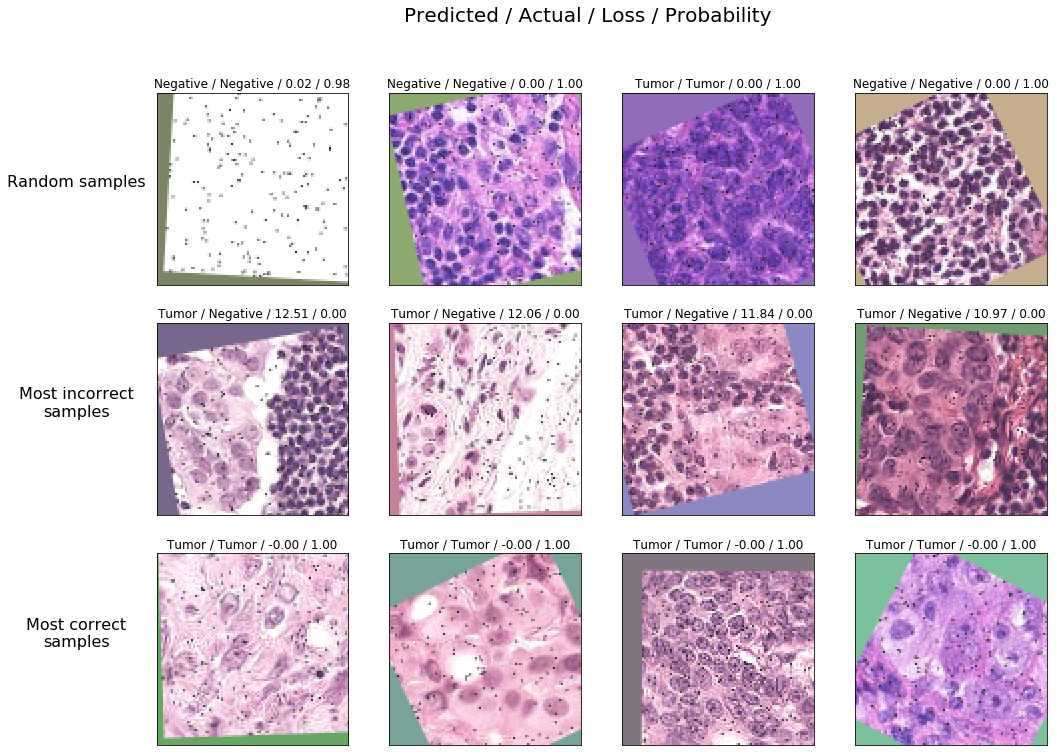

In [20]:
plot_overview(interp, ['Negative','Tumor']) # 调用上面这个函数

## Gradient-weighted Class Activation Mapping (Grad-CAM)加权梯度类激活映射:一种可视化解释基于梯度定位的深度网络
[Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

This method produces a coarse localization map highlighting the areas that the model considers important for the classification decision. The visual explanation gives transparency to the model making it easier to notice if it has learned the wrong things. For example, if we would train a dog breed classifier and all of our images of a certain dog breed would have been taken in a dog show competition. There is a good chance that the model would learn to recognize the competition surroundings instead of doggy features with that breed. Visualizing the localization map would reveal that, and we could focus on getting more diverse data of that breed.    
该方法产生粗略的定位图，突出显示模型认为对分类决策重要的区域。 视觉解释为模型提供了透明度(可解释性)，使得更容易注意到它是否已经学到了错误的东西。 例如，如果我们要训练一只狗品种分类器，我们所有的某种狗品种的图像都会在狗展中被拍摄。 该模型很有可能学会识别狗展环境而不是狗狗的特征。 可视化本地化地图将揭示这一点，我们可以专注于获得该品种的狗狗的更多样化数据。  

In [58]:
print("julyedu")

julyedu


In [21]:
from fastai.callbacks.hooks import *

# hook into forward pass 前向传播时自动调用这个钩子，用于检查和修改每一层的输出
# https://docs.fast.ai/callbacks.hooks.html#Hook
# https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#forward-and-backward-function-hooks

# fastai 回调 ： https://pouannes.github.io/blog/callbacks-fastai/
def hooked_backward(m, oneBatch, cat):
    # we hook into the convolutional part = m[0] of the model
    with hook_output(m[0]) as hook_a:  # 创建一个保存了模型激活函数输出的钩子 https://docs.fast.ai/callbacks.hooks.html#hook_output
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(oneBatch) # 输入oneBatch给构造的模型做预测
            preds[0,int(cat)].backward() # 反向传播
    # 两个解释，我暂时看不懂(通过上下文管理器删除钩子？)：
    # https://forums.fast.ai/t/lesson-6-advanced-discussion/31442/6
    # https://forums.fast.ai/t/lesson-6-advanced-discussion/31442/2
    return hook_a,hook_g

In [60]:
print("julyedu")

julyedu


In [22]:
# We can create a utility function for getting a validation image with an activation map
# 工具函数：画出一个验证集图片的热图
def getHeatmap(val_index):
    """Returns the validation set image and the activation map"""
    # 返回验证集图像和激活映射(热图)
    
    # this gets the model
    m = learner.model.eval()  
    # 评估模型
    # https://pytorch.org/tutorials/beginner/saving_loading_models.html
    # Remember that you must call model.eval() to set dropout and batch normalization 
    # layers to evaluation mode before running inference（推理预测）. 
    # Failing to do this will yield inconsistent inference results.

    tensorImg,cl = imgDataBunch.valid_ds[val_index]
    # valid_ds 是 validation的缩写 https://docs.fast.ai/dev/abbr.html
    # 输出图片列表tensorImg,类别列表cl，
    # https://dejanbatanjac.github.io/2019/03/15/ImageDataBunch.html
    # valid_ds 是 fastai v0.7 https://forums.fast.ai/t/how-to-get-data-val-ds-fnames-in-fastai-v1-0/37231

    
    # create a batch from the one image
    oneBatch,_ = imgDataBunch.one_item(tensorImg)
    # one_item  Get item into a batch. Optionally detach and denorm.  https://docs.fast.ai/basic_data.html#DataBunch.one_item
    # one_batch   Get one batch of from the DataBunch. Returns x,y with size of the batch_size (if bs=128 then there is a list of 128 elements).    https://docs.fast.ai/basic_data.html#DataBunch.one_batch
    # #get tensor from Image tensorfImg https://dhruvs.space/posts/grad-cam-heatmaps-along-resnet-34/

    
    oneBatch_im = vision.Image(imgDataBunch.denorm(oneBatch)[0])
    # denorm是denormalize的偏函数  https://docs.fast.ai/vision.data.html#denormalize
    # 反归一化denormalize的理解  https://stackoverflow.com/questions/4684622/how-to-normalize-denormalize-a-vector-to-range-11
    
    # convert batch tensor image to grayscale image with opencv从一个颜色空间到另一个颜色空间
    cvIm = cv2.cvtColor(image2np(oneBatch_im.data), cv2.COLOR_RGB2GRAY)
    # cv2.cvtColor https://docs.opencv.org/2.4.13.7/modules/imgproc/doc/miscellaneous_transformations.html#cv2.cvtColor
    # image2np  将图片从pytorch格式转为numpy格式  https://docs.fast.ai/vision.image.html#image2np
    
    # attach hooks 附上钩子？
    hook_a,hook_g = hooked_backward(m, oneBatch, cl) # 前面自定义的方法
    # get convolutional activations and average from channels
    
    acts = hook_a.stored[0].cpu()
    #avg_acts = acts.mean(0)
    # 这个钩子把激活的值存储到了stored里面，并放置到cpu里面

    # Grad-CAM
    grad = hook_g.stored[0][0].cpu()  #[0][0]??
    # 这个钩子把激活的值存储到了stored里面，并放置到cpu里面
    
    grad_chan = grad.mean(1).mean(1) # 求均值
    grad.shape,grad_chan.shape 
    mult = (acts*grad_chan[...,None,None]).mean(0)
    return mult, cvIm
    #mult是热点  cvIm是背景
# 生成热图的其他例子，方法挺类似的，有很多解释，有时间了细看，相信能解决很多疑惑：
# https://dhruvs.space/posts/grad-cam-heatmaps-along-resnet-34/

In [24]:
# Then, modify our plotting func a bit 终于开始画图函数啦（与前面的类似）
def plot_heatmap_overview(interp:ClassificationInterpretation, classes=['Negative','Tumor']):
    # interp 分类模型的效果解释函数 https://docs.fast.ai/vision.learner.html#ClassificationInterpretation
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    # top_losses 将返回所有 验证集的损失值(tl_val)和其索引(tl_idx) 按降序排序
    # top losses will return all validation losses and indexes sorted by the largest first
    
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    # matpoltlib subplots : 创建一系列的子图  nrows子图行的个数，ncols子图列的个数 ,figsize画布尺寸, ax子图的轴， fig图
    
    fig.suptitle('Grad-CAM\nPredicted / Actual / Loss / Probability',fontsize=20) #标题
    
    # Random 随机抽样
    for i in range(4):
        random_index = randint(0,len(tl_idx)) # 在(0,max_offset)之间随机生成一个整数
        idx = tl_idx[random_index] # 该验证集的索引
        act, im = getHeatmap(idx) # 得到该图片的热图和背景
        H,W = im.shape # 图片长宽
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx] # _ 是图片 cl 是类别class,值是0/1，0指代负例，1指代肿瘤
        cl = int(cl) # 转换为整数型
        ax[0,i].imshow(im) # 在第1行，第i+1列上展示背景图
        ax[0,i].imshow(im, cmap=plt.cm.gray) # 颜色图为灰度图
        ax[0,i].imshow(act, alpha=0.5, extent=(0,H,W,0), 
              interpolation='bilinear', cmap='inferno') 
        # 画出热图
        # interpolation插值：代表图片像素颜色没有过渡   https://blog.csdn.net/goldxwang/article/details/76855200
        # 某个点的值越大，颜色越深
        # alpha透明度
        # cmp : color map颜色图
        # extent 拉伸图像 https://www.cnblogs.com/lijiazhang/p/10105722.html
        # https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html
        ax[0,i].set_xticks([]) # 第一行第i个轴的x轴没有刻度
        ax[0,i].set_yticks([]) # 第一行第i个轴的y轴没有刻度
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')# 设置标题
#         ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')# 设置标题
        # f-string https://blog.csdn.net/qq_33453253/article/details/79653546
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80) # 给第一行第一个设置y轴标签

    # Most incorrect or top losses 展示前四个最不正确(损失值最大)的图例
    for i in range(4): # 只展示四张图
        idx = tl_idx[i] # # tl_idx的前四个是损失值最高的
        act, im = getHeatmap(idx) # 得到该图片的热图和背景
        H,W = im.shape # 图片长宽
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx] # _ 是图片 cl 是类别class,值是0/1，0指代负例，1指代肿瘤
        cl = int(cl) # 转换为整数型
        ax[1,i].imshow(im) # 在第1行，第i+1列上展示背景图
        ax[1,i].imshow(im, cmap=plt.cm.gray) # 颜色图为灰度图
        ax[1,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        # 同上
        ax[1,i].set_xticks([]) # 第二行第i个轴的x轴没有刻度
        ax[1,i].set_yticks([]) # 第二行第i个轴的y轴没有刻度
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}') # 设置标题
#         ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}') # 设置标题
        # f-string https://blog.csdn.net/qq_33453253/article/details/79653546
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80) # 给第二行第一个设置y轴标签
    
    # (同上)
    # Most correct or least losses 展示前四个最正确(损失值最小)的图例
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[2,i].imshow(im)
        ax[2,i].imshow(im, cmap=plt.cm.gray)
        ax[2,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')        
#         ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

In [64]:
print("julyedu")

julyedu


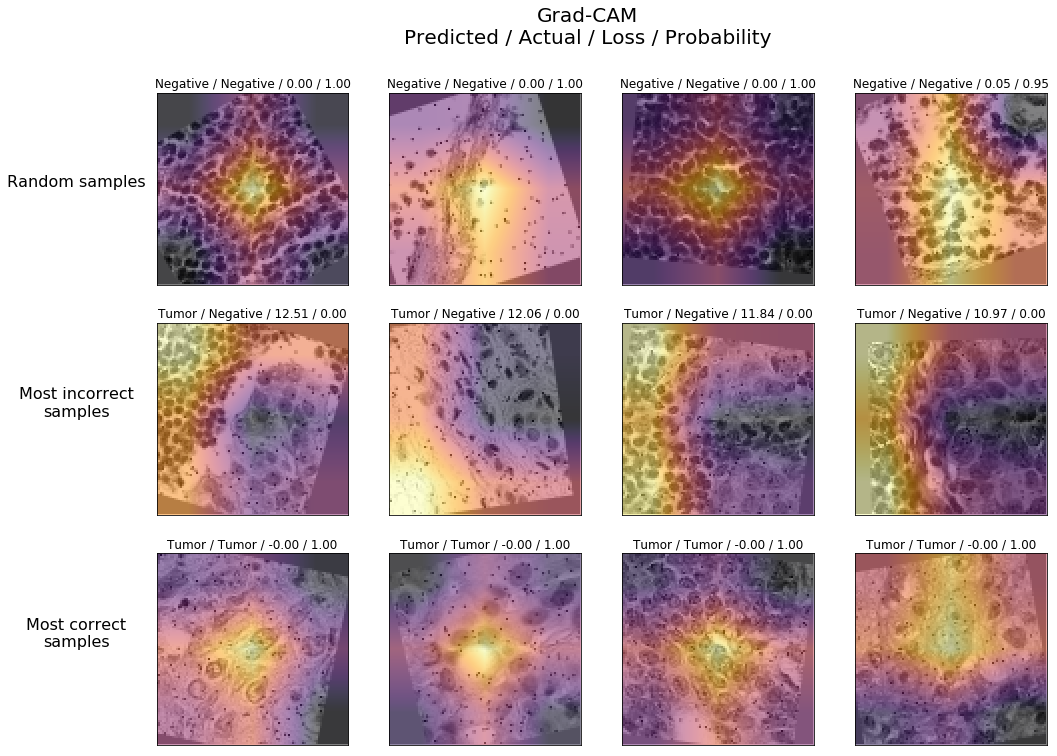

In [26]:
import cv2
plot_heatmap_overview(interp, ['Negative','Tumor']) # 调用上面的方法，画出热图

This shows the activation maps of the predicted category so if the label is ```tumor```, the visualization shows all the places where the model thinks the tumor patterns are.  
这显示了预测类别的激活图(热图)，因此如果标签是“肿瘤”，则可视化图 会显示 模型认为肿瘤所在的所有位置。

## ROC curve and AUC : ROC曲线和曲线下面积AUC  
Remember, AUC is the metric that is used for evaluating submissions. We can calculate it here for ou validation set but it will most likely differ from the final score.  
请记住，AUC是用于本次比赛的度量标准。 我们可以用验证集计算它，但它很可能与最终得分(测试集)不同。

In [66]:
print("julyedu")

julyedu


In [27]:
from sklearn.metrics import roc_curve, auc
# probs from log preds # 
probs = np.exp(preds[:,1]) # 计算每个元素的指数e^x
# Compute ROC curve # 计算ROC曲线
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)
# fpr 假阳性率 tpr：真阳性率 ,thresholds：阈值列表  y:真实标签 ， probs预测值，pos_label=1标签为1的是正例，其都是反例
# https://blog.csdn.net/u014264373/article/details/80487766
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn-metrics-roc-curve

# Compute ROC area # 计算曲面下面积
roc_auc = auc(fpr, tpr)
# https://scikit-learn.org/stable/modules/classes.html#classification-metrics
print('ROC area is {0}'.format(roc_auc)) # ROC area is 0.9942634117111718

ROC area is 0.9959498298736373


In [68]:
print("julyedu")

julyedu


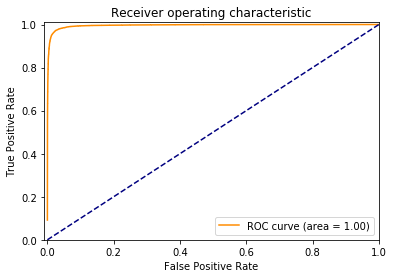

In [28]:
plt.figure() #matplotlib plt.figure:创建一个新图
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
#画出ROC曲线
plt.plot([0, 1], [0, 1], color='navy', linestyle='--') # 画出对角线
plt.xlim([-0.01, 1.0]) # 设置x轴上界和下界
plt.ylim([0.0, 1.01]) # 设置y轴上界和下界
plt.xlabel('False Positive Rate') # x轴标签是
plt.ylabel('True Positive Rate') # y轴标签是
plt.title('Receiver operating characteristic') # 图的上方标题
plt.legend(loc="lower right") # 设置图例

----------------

# Submit predictions提交预测文件
## TTA测试时增强(test time augmentation)  
To evaluate the model, we run inference on all test images. As we have test time augmentation, our results will probably improve if we do predictions multiple times per image and average out the results.   
为了评估模型，我们对所有测试图像进行推理预测。 测试时间增强，即对测试集中的图像进行数据增强并多次预测取平均，我们的结果可能会提高。  
https://www.kaggle.com/andrewkh/test-time-augmentation-tta-worth-it

In [29]:
# make sure we have the best performing model stage loaded 加载之前训练的效果最好的模型参数
learner.load(MODEL_PATH + '_stage2')

Learner(data=ImageDataBunch;

Train: LabelList (176020 items)
x: H5pyList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,0,1,0,0
Path: histo;

Valid: LabelList (44005 items)
x: H5pyList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,1,0,0,1
Path: histo;

Test: LabelList (10 items)
x: H5pyList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: histo, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): Batch

In [30]:


# Fastai has a function for this but we don't want the additional augmentations it does (our image loader has augmentations) so we just use the get_preds
#preds_test,y_test=learner.TTA(ds_type=DatasetType.Test)
#虽然fastai有测试时增强，但是我们之前加载数据的时候就做了数据增强，所以就不用再做了

# We do a fair number of iterations to cover different combinations of flips and rotations.
# 我们做了相当数量的迭代 来执行图像翻转和旋转的不同组合的操作。
# The predictions are then averaged.
# 然后对预测结果取平均
n_aug = 12
# 增强次数
preds_n_avg = np.zeros((len(learner.data.test_ds.items),2))
# 设置一个预测值矩阵，初始值为0，形状是(len(learner.data.test_ds.items):测试集数目 , 2：反例和正例概率

for n in tqdm_notebook(range(n_aug), 'Running TTA...'): # tqdm_notebook可用于显示进度条，其第二个参数是提示用的
    preds,y = learner.get_preds(ds_type=DatasetType.Test, with_loss=False)
    # preds预测值、y预测标记  with_loss=False不计损失值  https://docs.fast.ai/basic_train.html#Learner.get_preds    
    preds_n_avg = np.sum([preds_n_avg, preds.numpy()], axis=0)
    # (2, 57458, 2) -> (57458, 2) 对第一个维度聚合相加，也可以简单理解为两个矩阵的元素对应相加
preds_n_avg = preds_n_avg / n_aug # 对这几次概率之和求平均

In [72]:
print("julyedu")

julyedu


In [31]:
# Next, we will transform class probabilities to just tumor class probabilities
print('Negative and Tumor Probabilities: ' + str(preds_n_avg[0])) # 第一行 第一个样本的反例和正例的概率
tumor_preds = preds_n_avg[:, 1] # 概率矩阵第二列 即癌症的概率
print('Tumor probability: ' + str(tumor_preds[0])) # 第一个样本是正例(癌症)的概率
# If we wanted to get the predicted class, argmax would get the index of the max
class_preds = np.argmax(preds_n_avg, axis=1) 
# 顺着第一个维度(行)求最大值的坐标，即求每个样本的概率最大的坐标(0或1)
# https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.argmax.html

classes = ['Negative','Tumor'] # preds_n_avg 0 对应了Negative , 1对应了 Tumor
print('Class prediction: ' + classes[class_preds[0]])

Negative and Tumor Probabilities: [3.205167e-04 9.996794e-01]
Tumor probability: 0.999679446220398
Class prediction: Tumor


## Submit the model for evaluation提交
We need to submit the tumor probability for each test sample in this competition. The probability ranges from 0 to 1.  
我们需要提交每个测试样本是癌症的概率，这个概率的取值范围是(0,1)

In [74]:
print("julyedu")

julyedu


In [33]:
# get test id's from the sample_submission.csv and keep their original order
# 从提交模板中取得id并保持其顺序
# 从sample_submission.csv这个文件中，提取测试集的id，并保持原有的顺序
SAMPLE_SUB = '/home/julyedu_465286/histo/sample_submission.csv'
sample_df = pd.read_csv(SAMPLE_SUB) #pandas 读csv文件:提交文件
sample_list = list(sample_df.id) # dataframe.columns   提交文件的id列 ;Series转换为list

# List of tumor preds. 生成癌症预测概率列表
# These are in the order of our test dataset and not necessarily in the same order as in sample_submission
# 这些预测概率是按照我们测试集中的顺序排列的，稍后要重新排序
pred_list = [p for p in tumor_preds] #numpy.ndarray -> list  python列表生成式

# To know the id's, we create a dict of id:pred 把我们的id和预测值 组成 一个字典
pred_dic = dict((key, value) for (key, value) in zip(learner.data.test_ds.items, pred_list))
# python zip 把多个序列的元素对应编织在一起  https://www.python.org/dev/peps/pep-0201/#id10

# Now, we can create a new list with the same order as in sample_submission
# 现在，我们要创建一个和提交模板顺序相同的列表
pred_list_cor = [pred_dic['///kaggle/input/histopathologic-cancer-detection/test/' + id + '.tif'] for id in sample_list]
# 循环地提取sample_list中的id，找到其在pred_dice字典中对应的值，生成一个规定顺序的预测概率列表

# Next, a Pandas dataframe with id and label columns.
df_sub = pd.DataFrame({'id':sample_list,'label':pred_list_cor})
# 生成一个dataframe，第一列是提交模板的id，第二列label是按照规定顺序排列的预测概率

# Export to csv
df_sub.to_csv('{0}_submission.csv'.format(MODEL_PATH), header=True, index=False)
# dataframe to_csv 将dataframe转换为csv文件，header=True保留列名，index=False不要保存索引

TypeError: 'dict' object is not callable

In [76]:
# This is what the first 10 items of submission look like 查看提交数据的前十行
df_sub.head(10)
# pandas dataframe head 

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.000735
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.027735
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.000200
3,2c35657e312966e9294eac6841726ff3a748febf,0.001238
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.005074
5,725dabe6ecccc68b958a2c7dd75bcbf362c7cb03,0.996941
6,aa0307865281d4484ddf8c637c348292968b93a7,0.154352
7,f4e5dc9c949920f1b3362982e15e99bf6f3ef83b,0.407655
8,95e08c9cedc28a9b4a86f4fc1e06c1972134be08,0.000394
9,ee1f5345a8d4e28403b7e61b97b5f76c201ce9cb,0.003138


# 部署Deploy (或测试example)
Now that we have a working model. We could deploy this for inference to another machine, a web server for example.  
现在我们有了一个有效的模型。我们需要部署这个模型到另一台机器用于推理预测，比如一个web服务器。
  
  
  For this, we need our saved model, and then we need to export the  DataBunch.  



**Note**. I haven't tried these so I cannot guarantee these will work straight away. You may need to do some debugging.我还没有尝试这些，不保证能立刻工作，可能需要一些调试。  
[Official documentation官方文档](https://docs.fast.ai/tutorial.inference.html).  


In [77]:
print("julyedu")

julyedu


In [34]:
# This will create an export.pkl file that you'll need to copy with your model file if you want to deploy it on another device.
# This saves the internal information (classes, etc) need for inference in a file named 'export.pkl'. 
imgDataBunch.export(file='./export.pkl') # 存储模型推理预测所需要的最少的信息
# https://docs.fast.ai/data_block.html#LabelList.export
# https://github.com/fastai/fastai/blob/c15331a7b8b9fa908dbe6c0bcb38ba124e0d2768/fastai/data_block.py#L663

**On a new machine在一台新机器里**
We need to create an empty DataBunch and load it to a learner.  
我们需要创建一个空的DataBunch，然后将它加载到cnn_learner中，因为是推理预测不需要数据。

In [79]:
######## RUN THIS ON A NEW MACHINE请在另一台新机器上运行下面的代码 ##########
# from fastai.vision import * # 包含定义计算机视觉中的数据集和训练模型所必须的函数
# from fastai import * # 更快、更简单、更先进的深度学习库
# from torchvision.models import *  # pytorch视觉模块
#arch = densenet169       # specify model architecture 所用的模型架构
#MODEL_PATH = str(arch).split()[1] + '_stage2' # 训练的模型权重
#empty_data = ImageDataBunch.load_empty('./') #这会自动搜索export.pkl文件：this will look for a file named export.pkl in the specified path
#learner = create_cnn(empty_data, arch).load(MODEL_PATH)
# 定义一个卷积神经网络，空数据，densenet169,权重采用MODEL_PATH

In [80]:
print("julyedu")

julyedu


This is a negative tissue image.


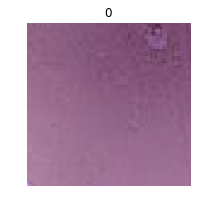

In [81]:
## And then we are ready to do predictions 然后我们就可以开始推理预测了
import cv2 # opencv
sz = 68

# This function will convert image to the prediction format #转换图像格式到模型想要的格式
def imageToTensorImage(path):
    # OpenCV reads the image in bgr format by default 用opencv读取图片，通道格式默认是bgr
    bgr_img = cv2.imread(path) 
    # cv2.split函数分离得到各个通道的灰度值(单通道图像)  https://blog.csdn.net/eric_pycv/article/details/72887758
    b,g,r = cv2.split(bgr_img)
    # cv2.merge函数是合并单通道成多通道（不能合并多个多通道图像） 
    rgb_img = cv2.merge([r,g,b])
    # crop to center to the correct size and convert from 0-255 range to 0-1 range
    # 剪裁图像的重心到正确的尺寸，然后将像素值从0-255 缩放到 0-1 的范围
    H,W,C = rgb_img.shape # 图像长、宽，通道数
    rgb_img = rgb_img[(H-sz)//2:(sz +(H-sz)//2),(H-sz)//2:(sz +(H-sz)//2),:] / 256
    # (H-sz)//2是中心小图的x轴的切片的起点，(sz +(H-sz)//2是x轴的切片的终点。
    # (H-sz)//2是中心小图的y轴的切片的起点，(sz +(H-sz)//2)是y轴的切片的终点。
    # 保持通道数不变
    
    return vision.Image(px=pil2tensor(rgb_img, np.float32))
    # This ndarray image has to be converted to tensor before passing on as fastai Image, we can use pil2tensor  
    # 这个ndarray图像必须在传递为fastai Image之前转换为张量tensor格式，我们可以使用pil2tensor方法实现
    # pil2tensor把pil格式的图片数组转换为torch格式的图片张量
    # https://docs.fast.ai/vision.image.html#Images

        
img = imageToTensorImage('/kaggle/input/histopathologic-cancer-detection/test/0eb051700fb6b1bf96188f36c8e4889598c6a157.tif')
# 调用上面定义的函数，生成了一个Image对象  https://docs.fast.ai/vision.image.html#Image

## predict and visualize 预测和图像可视化
img.show(y=learner.predict(img)[0]) # y是图的标题
# 展示图像 https://docs.fast.ai/vision.image.html#Image.show

# learner.predict(img) 推理预测，三个返回值是predicted class, label and probabilities
# 第一个返回值y=learner.predict(img)[0]是预测的类别，0对应了反例negative即正常，1对应了正例即癌症tumor
# https://docs.fast.ai/vision.learner.html#Learner.predict
classes = ['negative', 'tumor']
print('This is a ' + classes[int(learner.predict(img)[0])] + ' tissue image.')
# 当int(learner.predict(img)[0])是0时，classes[int(learner.predict(img)[0])]是negative。
# 当int(learner.predict(img)[0])是1时，classes[int(learner.predict(img)[0])]是tumor。


# 学生可能会问的问题：  
1.为什么用densenet169  
resnet好像有人觉得也不错： 
https://www.kaggle.com/c/histopathologic-cancer-detection/discussion/84790

2.有些人怎么能达到1？  
https://www.kaggle.com/kokecacao/how-to-get-1-000-lb-1-000/comments
https://www.kaggle.com/c/histopathologic-cancer-detection/discussion/85283  
https://www.kaggle.com/c/histopathologic-cancer-detection/discussion/86567 
https://www.kaggle.com/c/histopathologic-cancer-detection/discussion/84132#latest-495089
https://www.kaggle.com/c/histopathologic-cancer-detection/discussion/85283#latest-499241

3.How to get 0.98+ AUC
https://www.kaggle.com/c/histopathologic-cancer-detection/discussion/83760
https://www.kaggle.com/c/histopathologic-cancer-detection/discussion/84790

How to get 0.9788
https://www.kaggle.com/c/histopathologic-cancer-detection/discussion/81747#latest-507023

Ensemble and TTA Can help to boost your score
https://www.kaggle.com/c/histopathologic-cancer-detection/discussion/83313#latest-497434

相似比赛方案：  
https://www.kaggle.com/c/histopathologic-cancer-detection/discussion/71918#latest-473189  

How to do TTA with PyTorch  
https://www.kaggle.com/c/histopathologic-cancer-detection/discussion/84056#latest-490860  

How I drop from 0.9805 Private LB to 0.974 (113rd Solution)反思  
https://www.kaggle.com/c/histopathologic-cancer-detection/discussion/87367#latest-504483

为什要对数据标准化  
The recommended preprocessing is to center the data to have mean of zero, and normalize its scale to [-1, 1] along each feature  
http://cs231n.github.io/neural-networks-2/#datapre  

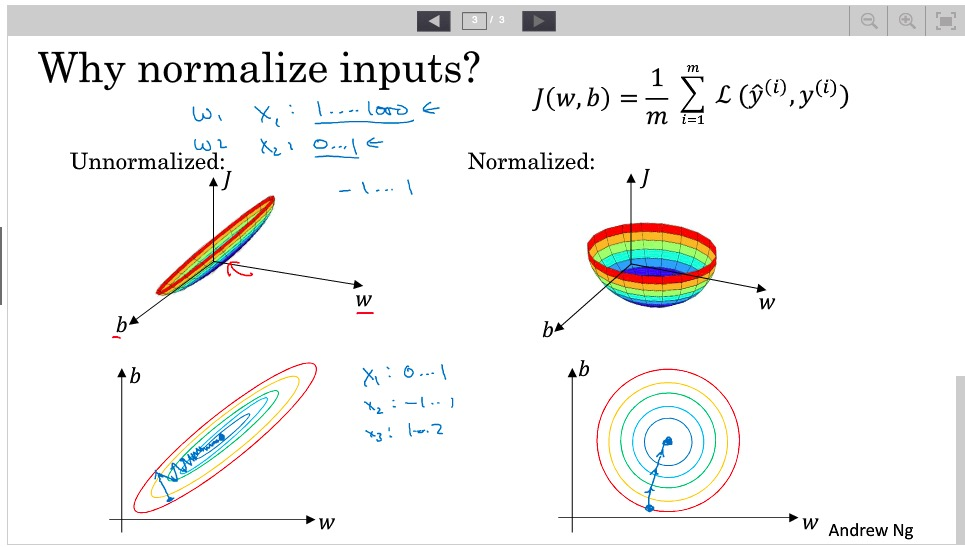  
deeplearning.ai  
改善深层神经网络：超参数调试、正则化以及优化  
所属微专业： 深度学习工程师  
1.9  正则化输入  

一些讨论  
https://forums.fast.ai/t/images-normalization/4058

In [82]:
# 下载文件到本地
from IPython.display import HTML
import pandas as pd
import numpy as np
df = pd.DataFrame(np.arange(1000), columns=['data'])

df.to_csv('submission.csv')

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='export.pkl')